<center><h1>Data Manipulation: Forming a Weekly Time Series<br><p style="font-size:8">(Data Manipulation and ARIMA Modeling with Pyramid)</p></h1></center>

# 0. Prelim

## 0.1 Packages

In [37]:
from pathlib import Path

import datetime

import numpy as np
import pandas as pd


import prophet
from statsmodels.tsa.arima.model import ARIMA

from matplotlib import pyplot as plt
from statsmodels.graphics import tsaplots


## 0.2 Paths

In [8]:
DATA_FOLDER = Path("../../../data")
INTERMEDIATE_DATA_FOLDER = DATA_FOLDER / "intermediate"

# 1. Extract Data

In [9]:
# A. Extract Data
df_weekly_cancelations = pd.read_parquet(INTERMEDIATE_DATA_FOLDER / "df_weekly_cancelations.parquet")

# B. Display
print("Descriptive Statistics:")
print("-----------------------")
print(f"Shape : {df_weekly_cancelations.shape}")
print(f"Date Range: {df_weekly_cancelations['ArrivalDate'].min() : %Y-%m-%d} - {df_weekly_cancelations['ArrivalDate'].max() : %Y-%m-%d}")
print("\n\n")
print(f"Columns:")
print(f"--------")
display(df_weekly_cancelations.dtypes)
print("\n\n")
print(f"Quality Check:")
print(f"--------------")
display(df_weekly_cancelations.loc[df_weekly_cancelations['Date (Year and Week Number)'].isin(['201527', '201528', '201529']), ['Date (Year and Week Number)', 'IsCanceled']])
display(df_weekly_cancelations)

Descriptive Statistics:
-----------------------
Shape : (114, 3)
Date Range:  2015-07-05 -  2017-09-03



Columns:
--------


ArrivalDate                    datetime64[ns]
IsCanceled                              int64
Date (Year and Week Number)            object
dtype: object




Quality Check:
--------------


,Date (Year and Week Number),IsCanceled
0,201527,41
1,201528,48
2,201529,87


,ArrivalDate,IsCanceled,Date (Year and Week Number)
0,2015-07-05,41,201527
1,2015-07-12,48,201528
2,2015-07-19,87,201529
3,2015-07-26,74,201530
4,2015-08-02,101,201531
...,...,...,...
109,2017-08-06,173,201732
110,2017-08-13,140,201733
111,2017-08-20,182,201734
112,2017-08-27,143,201735


# 2. Explorative Analysis

## 2.1 Get Time Series Component

02:28:18 - cmdstanpy - INFO - Chain [1] start processing
02:28:18 - cmdstanpy - INFO - Chain [1] done processing


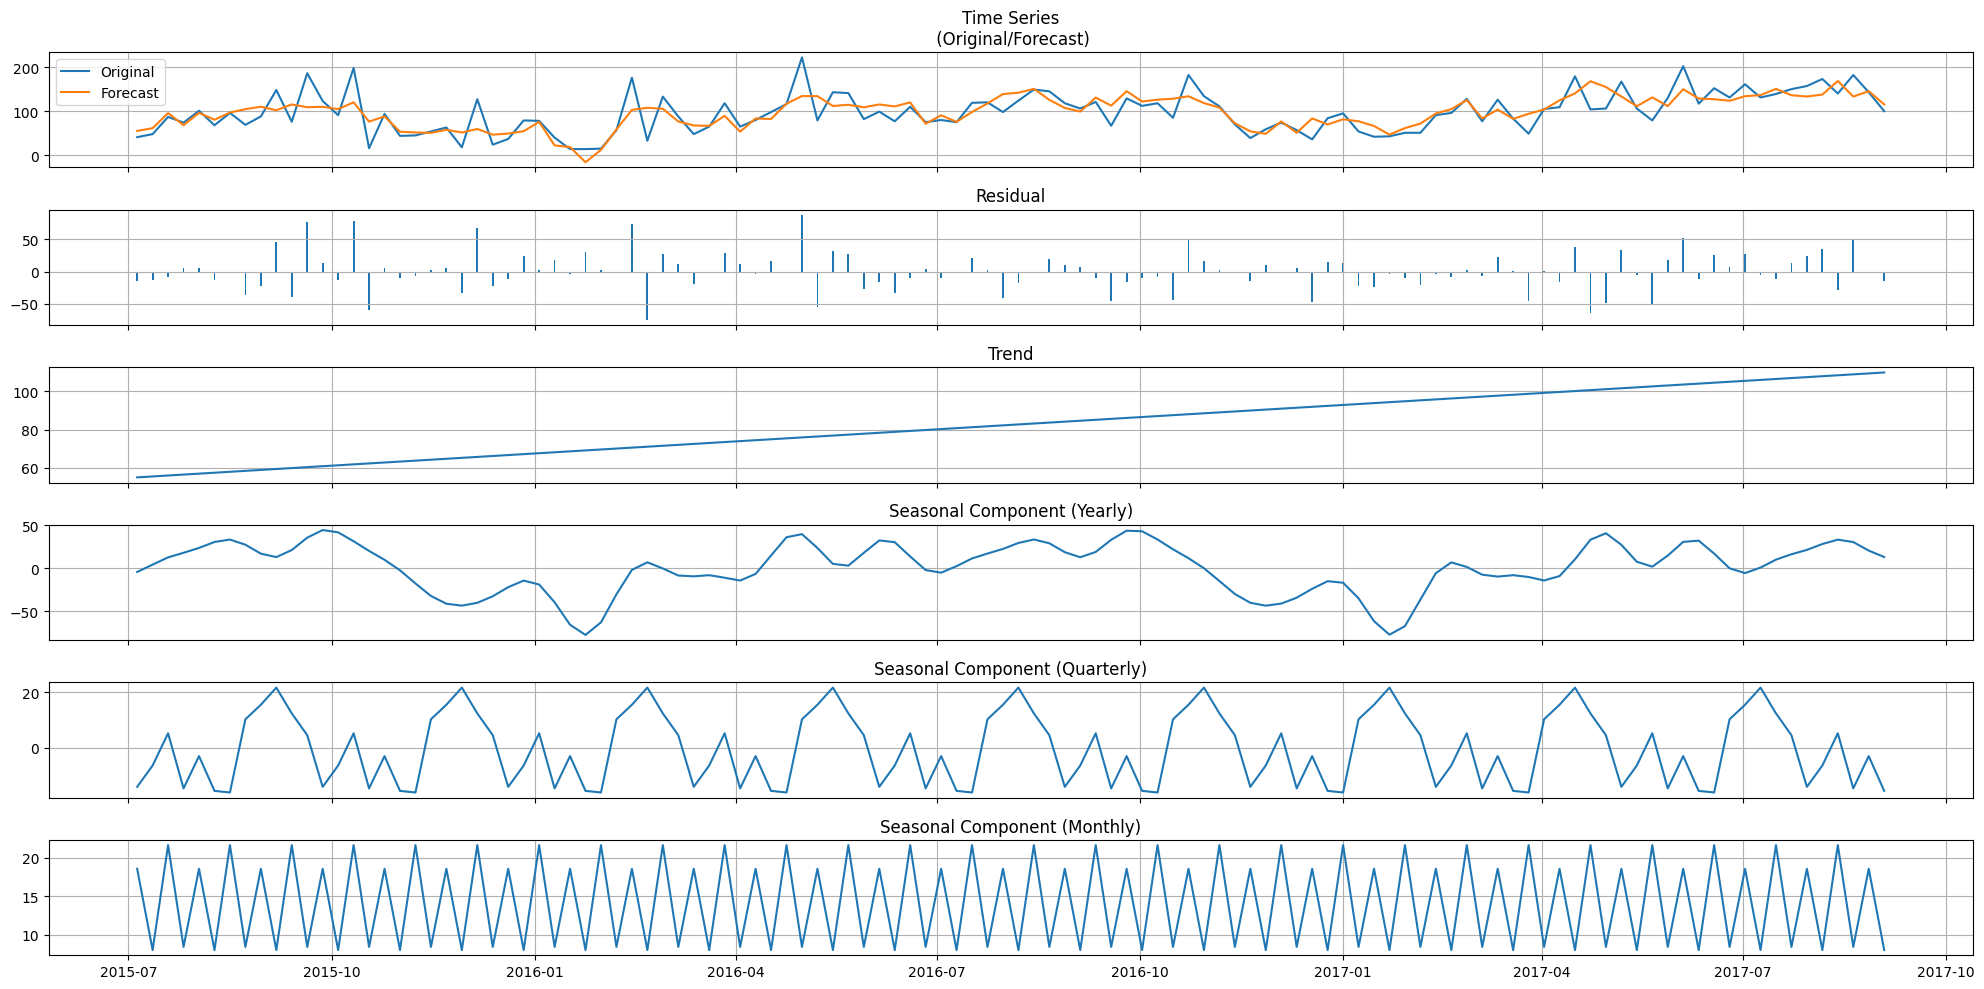

In [11]:
# A. Preparation
df_weekly_cancelations_decompose_model = df_weekly_cancelations.rename(columns={'ArrivalDate' : 'ds', 'IsCanceled' : 'y'})

# B. Modeling
# B1. Define Model
decomposition_model = prophet.Prophet()
decomposition_model.add_seasonality(period=4, fourier_order=5, name='monthly')
decomposition_model.add_seasonality(period=12, fourier_order=5, name='quarterly')
# B2. Train Model
decomposition_model.fit(df_weekly_cancelations_decompose_model)
# B3. Make a Forecast
forecast = decomposition_model.predict(decomposition_model.make_future_dataframe(periods=52, freq='w'))
forecast = pd.merge(forecast, df_weekly_cancelations_decompose_model[['ds', 'y']], on='ds', how='inner')

# C. Plot Components
fig, axs = plt.subplots(nrows= 6, ncols=1, figsize=(20,10), sharex=True)
axs = axs.flatten()
for ax in axs:
    ax.grid(True)
# Original/Estimated Time Series
axs[0].plot(forecast['ds'], forecast['y'], label='Original')
axs[0].plot(forecast['ds'], forecast['yhat'], label='Forecast')
axs[0].legend()
axs[0].set_title("Time Series\n (Original/Forecast)")
axs[1].bar(forecast['ds'], forecast['y']-forecast['yhat'])
axs[1].set_title("Residual")
axs[2].plot(forecast['ds'], forecast['trend'])
axs[2].set_title("Trend")
axs[3].plot(forecast['ds'], forecast['yearly'])
axs[3].set_title("Seasonal Component (Yearly)")
axs[4].plot(forecast['ds'], forecast['quarterly'])
axs[4].set_title("Seasonal Component (Quarterly)")
axs[5].plot(forecast['ds'], forecast['monthly'])
axs[5].set_title("Seasonal Component (Monthly)")
fig.tight_layout()



## 2.2 Autocorrelation

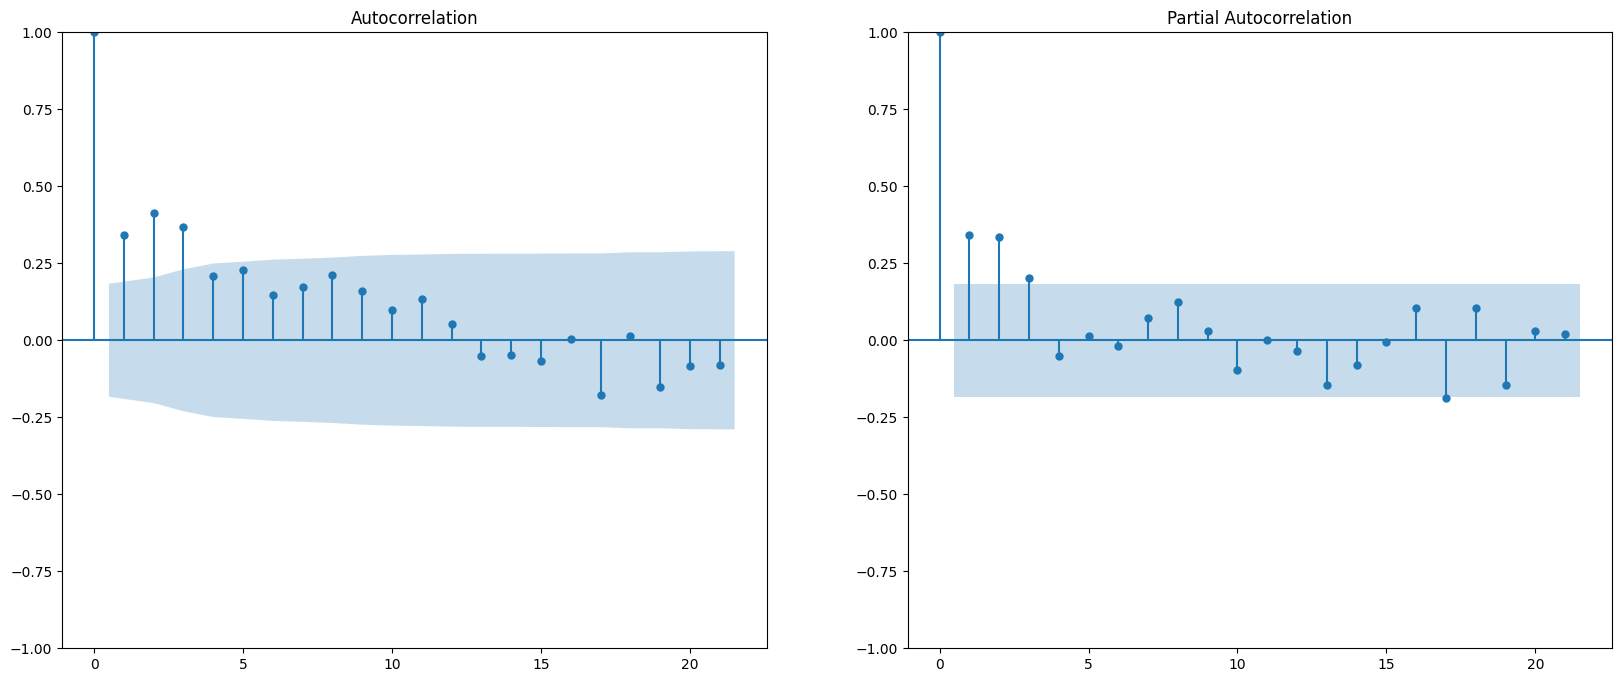

In [36]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
axs = axs.flatten()
tsaplots.plot_acf(df_weekly_cancelations_decompose_model['y'], ax=axs[0])
tsaplots.plot_pacf(df_weekly_cancelations_decompose_model['y'], ax=axs[1])
plt.show()

# 2. Modeling

## 2.1 Train-Test Split

In [13]:
ts_train = forecast.sort_values(by='ds').iloc[:int(forecast.shape[0]*0.9)]
ts_test = forecast.sort_values(by='ds').iloc[int(forecast.shape[0]*0.9):]

### 2.2 Training

In [14]:
# A. Statsmodel
arma_model = ARIMA(endog=ts_train.set_index('ds')['y'], order=(0, 0, 4))
trained_arma_model = arma_model.fit()
print(trained_arma_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  102
Model:                 ARIMA(0, 0, 4)   Log Likelihood                -521.312
Date:                Wed, 27 Sep 2023   AIC                           1054.624
Time:                        02:28:37   BIC                           1070.374
Sample:                    07-05-2015   HQIC                          1061.002
                         - 06-11-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         91.8285      7.822     11.740      0.000      76.498     107.159
ma.L1          0.1352      0.100      1.356      0.175      -0.060       0.331
ma.L2          0.2779      0.135      2.058      0.0

/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


## 2.3 Forecasting

Text(0.5, 1.0, 'Time Series Forecasting\nOriginal Time Series/MA(4) Forecast/SMA(4) Forecast')

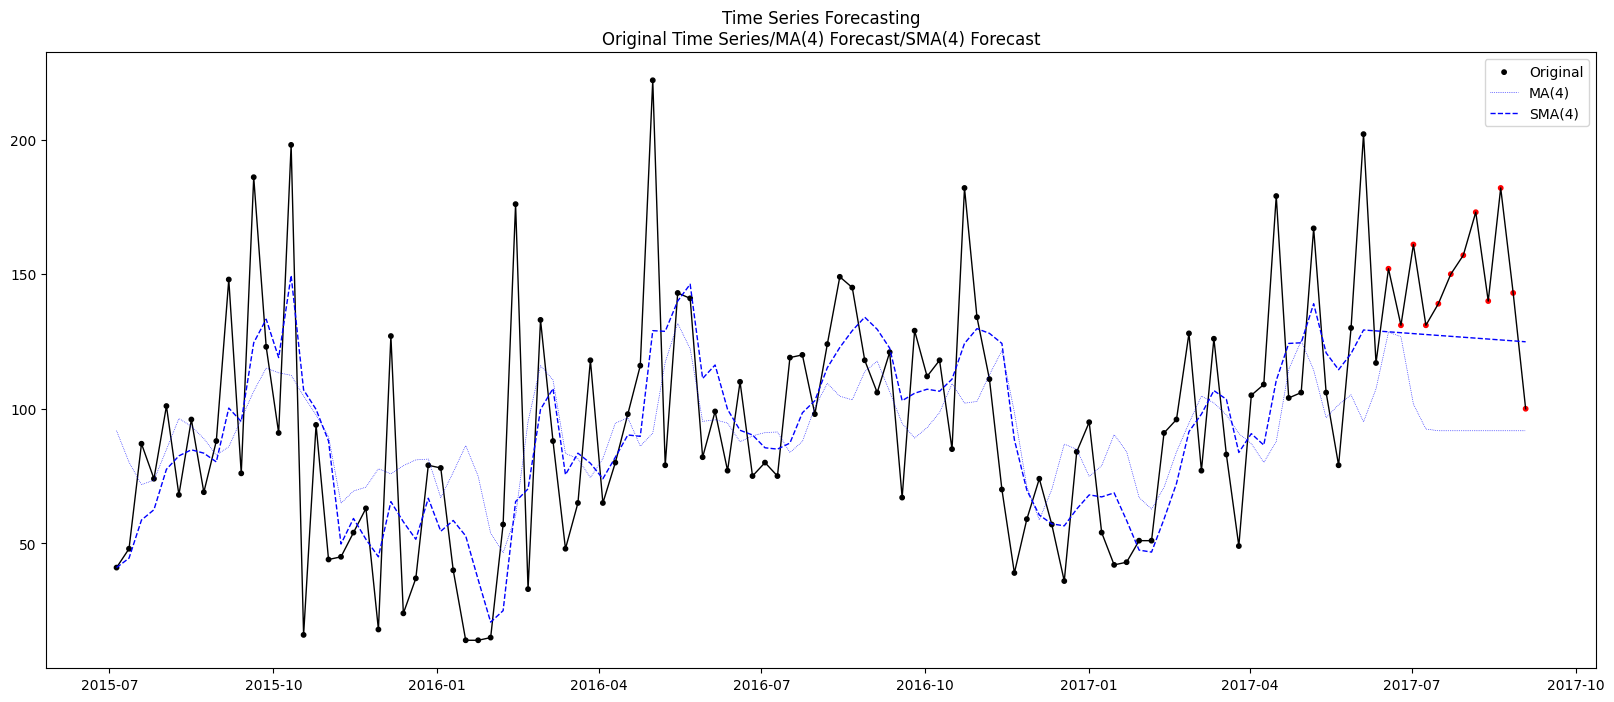

In [79]:
# A. Forecasting
# A1. MA(4)
ma_forecast = trained_arma_model.predict(start=forecast['ds'].min(), end=forecast['ds'].max())
# A2. SMA(4)
sma_forecast = ts_train[['ds','y']].rolling('28D', on='ds').mean()
for _ in range(ts_test.shape[0]):
    sma_forecast.iloc[-1]=(sma_forecast.iloc[-1,0]+datetime.timedelta(days=7),sma_forecast.iloc[-3:,1].mean())
sma_forecast = sma_forecast.set_index('ds')

# B. Display
fig = plt.figure(figsize=(20,8))
plt.scatter(forecast['ds'], forecast['y'], label='Original', color=['black']*int(forecast.shape[0]*0.9)+['red']*(forecast.shape[0]-int(forecast.shape[0]*0.9)), s=10)
plt.plot(forecast['ds'], forecast['y'], color='black', linewidth=1)
plt.plot(ma_forecast, ':b', label='MA(4)', linewidth=0.5)
plt.plot(sma_forecast, '--b', label='SMA(4)', linewidth=1)
plt.legend()
plt.title("Time Series Forecasting\nOriginal Time Series/MA(4) Forecast/SMA(4) Forecast")